nmon [-40.44981847 -34.15386066 -27.60899723 -20.50857953 -13.85075396
 -12.78663957]


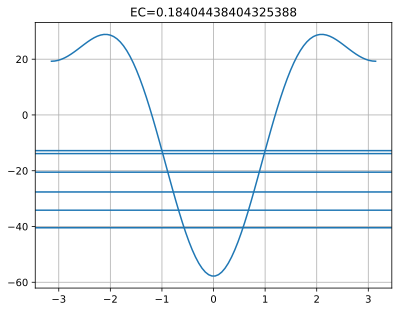

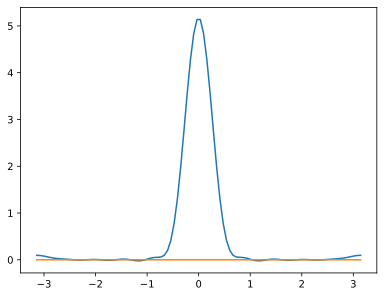

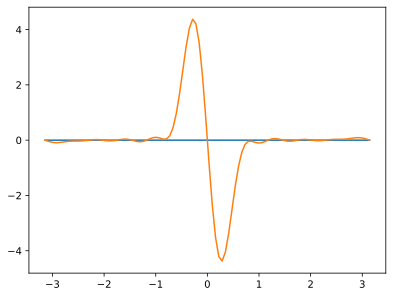

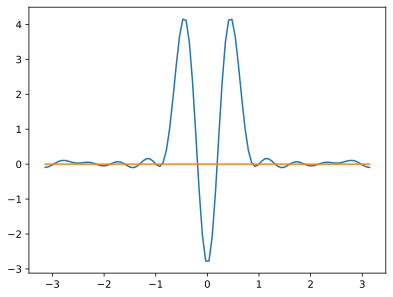

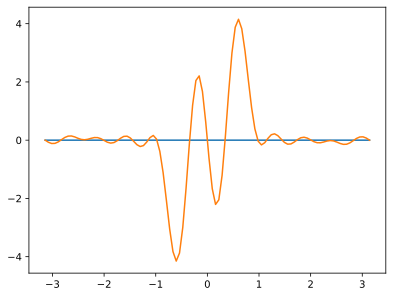

 /Users/nikolaygusarov/Library/Python/3.9/lib/python/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py: 1272

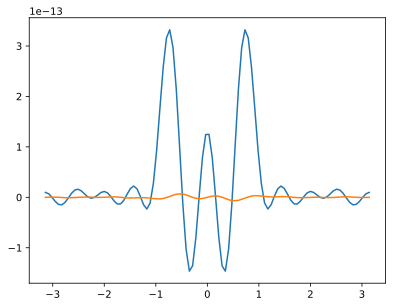

 /Users/nikolaygusarov/Library/Python/3.9/lib/python/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py: 1272

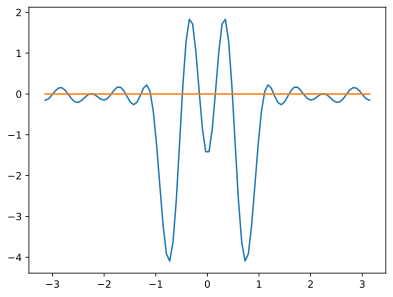

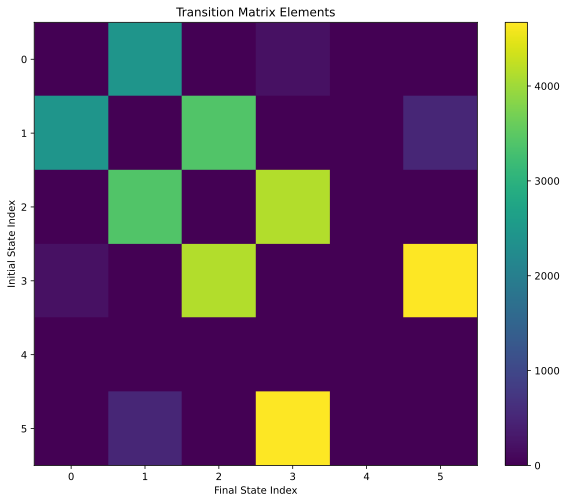

In [4]:
from nmon import *

nmon = Nmon(N=1, M=2, EJM=1, EJN=1)
# nmon = Nmon(N=1, M=2,EJM=20*nmon.EC_total, EJN=20*nmon.EC_total)
nmon = Nmon(N=1, M=2, EJM=100*nmon.EC_total, EJN=100*nmon.EC_total)
nmon.hamiltonian_calc(flux=0, ng=[0, 0], make_plot=True)

In [4]:
print("EC", nmon.EC_total)
print("EC shunt", nmon.EC_shunt)
print("total C", nmon.C_total)

print('total L', nmon.L_total)
print('Expected freq', 1/ np.sqrt(nmon.L_total*nmon.C_total)/1e9)

print("EJM", nmon.EJM)
print("EJN", nmon.EJN)
print("ECJM", nmon.ECJM)
print("ECJN", nmon.ECJN)

print(nmon.bound_state_energies[1] - nmon.bound_state_energies[0])
print(nmon.bound_state_energies[2] - nmon.bound_state_energies[1])

# print(nmon.bound_state_energies[2] - nmon.bound_state_energies[0])
# print(nmon.bound_state_energies[4] - nmon.bound_state_energies[2])
# print(nmon.bound_state_energies[4] - nmon.bound_state_energies[2])
print(nmon.transition_freqs)
print(nmon.relative_anharm)

EC 0.19308256253686182
EC shunt 0.1931783881678237
total C 1.0004962935528869e-13
total L 5.651154321100102e-07
Expected freq 4.205558460634797
EJM 0.19268209461493685
EJN 0.19268209461493685
ECJM 583.8632812500001
ECJN 583.8632812500001
0.7917507190863363
0.02341297628203176
[0.7917507190863363, 2.322602514784223, 3.860729373162323]
1.9335022486174154


In [1]:
from nmon import *

N_EJN = 20
N_EJM = 20

nmon = Nmon(N=1, M=2, EJM=1, EJN=1)

EJM_list = np.linspace(1*nmon.EC_total, 100*nmon.EC_total, N_EJN)
EJN_list = np.linspace(1*nmon.EC_total, 100*nmon.EC_total, N_EJM)

relative_anharm_list = np.zeros((N_EJM , N_EJN))
w01_list = np.zeros((N_EJM , N_EJN))
w12_list = np.zeros((N_EJM , N_EJN))
w01_variation_list = np.zeros_like(w01_list)

for i in tqdm(range(N_EJM)):
    for j in range(N_EJN):
        w01_local = np.zeros(3)

        nmon = Nmon(N=1, M=2, EJM=EJM_list[i], EJN=EJN_list[j])
        nmon.hamiltonian_calc(flux=0, ng=[0, 0])
        relative_anharm_list[i, j] = nmon.relative_anharm
        w01_list[i, j] = nmon.transition_freqs[0]
        try:
            w12_list[i, j] = nmon.transition_freqs[1]
        except Exception as e:
            print(e)
            print(nmon.EC_total, nmon.EJN, nmon.EJM, nmon.transition_freqs, nmon.bound_state_energies)
            print()



        w01_local[0] = w01_list[i, j]
        nmon.hamiltonian_calc(flux=0, ng=[0, 0.5], num_levels=2)
        w01_local[1] = nmon.transition_freqs[0]
        nmon.hamiltonian_calc(flux=0, ng=[0.5, 0.5], num_levels=2)
        w01_local[2] = nmon.transition_freqs[0]

        w01_variation_list[i, j] = (np.max(w01_local) - np.min(w01_local))/np.min(w01_local)

100%|██████████| 20/20 [09:31<00:00, 28.59s/it]ython/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py: 1272


In [2]:
np.save("./data_arrays/N={}_M={}_EC={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_total,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_total,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_total,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_total,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_total,2 )), w01_variation_list)


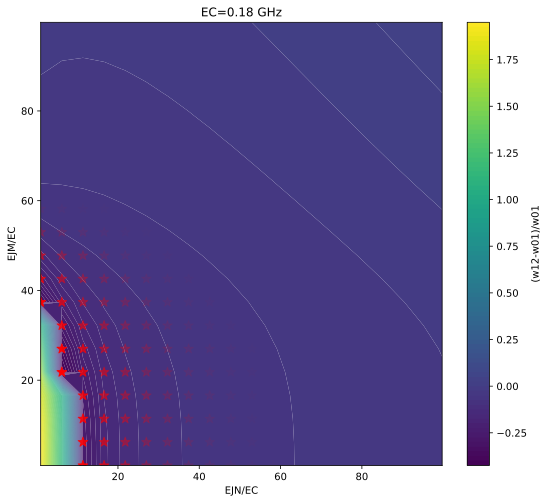

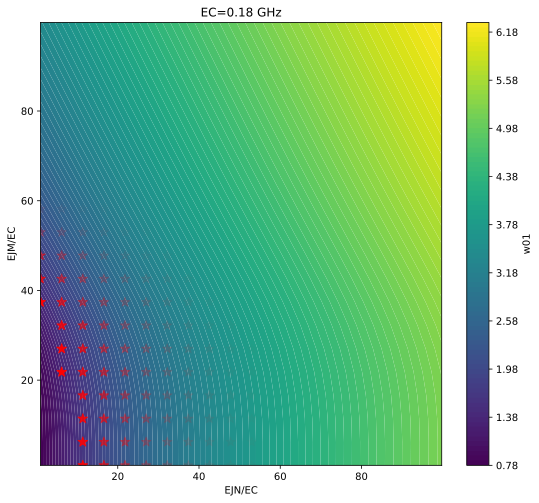

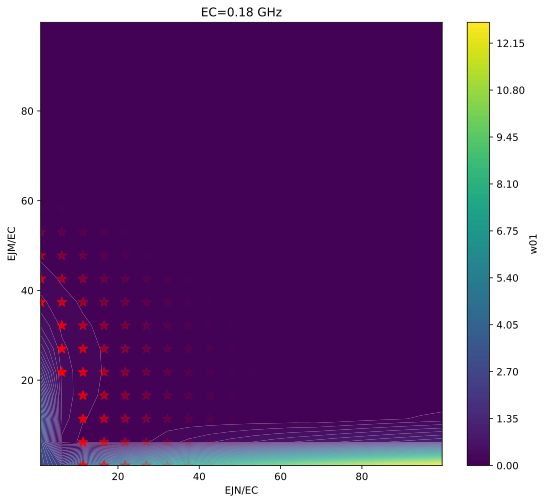

In [3]:

N_anharm = 100
# Find the indices of the 10 smallest values in relative_anharm_list
sorted_indices_flat = np.argsort(relative_anharm_list, axis=None)[:N_anharm]
min_indices = np.unravel_index(sorted_indices_flat, relative_anharm_list.shape)

# Extract the anharmonicity values for the 10 best points
best_anharm_values = relative_anharm_list[min_indices]

# Initialize alpha values as 1 for all
alphas = np.ones(N_anharm)

# Check if the differences between adjacent anharmonicities are smaller than 1e-3
for i in range(1, N_anharm):
    if abs(best_anharm_values[i] - best_anharm_values[i - 1]) > 1e-3:
        alphas[i:] = np.logspace(0, -2, N_anharm - i)  # Adjust alphas for remaining points
        break

plt.figure(figsize=(9, 8))
# plt.imshow(relative_anharm_list, cmap='viridis', interpolation='nearest')

EJN_grid, EJM_grid = np.meshgrid(EJN_list, EJM_list)

plt.contourf(EJN_grid/nmon.EC_shunt, EJM_grid/nmon.EC_shunt, relative_anharm_list, levels=100)
plt.colorbar(label='(w12-w01)/w01')
plt.xlabel('EJN/EC')
plt.ylabel('EJM/EC')
# Loop through the 10 best indices and plot them with varying alphas
# Loop through the 10 best indices and plot them with varying or identical alphas
for i in range(N_anharm):
    plt.scatter(EJN_list[min_indices[1][i]]/nmon.EC_shunt, EJM_list[min_indices[0][i]]/nmon.EC_shunt, 
                s=100, c='red', marker='*', alpha=alphas[i])

    
plt.title("EC={} GHz".format(round(nmon.EC_total,2 )))
# plt.xticks(ticks=np.arange(len(EJM_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJM_list[::2]])
# plt.yticks(ticks=np.arange(len(EJN_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJN_list[::2]])
plt.show()

plt.figure(figsize=(9, 8))
plt.contourf(EJN_grid/nmon.EC_shunt, EJM_grid/nmon.EC_shunt, w01_list, levels=100)
plt.colorbar(label='w01')
plt.xlabel('EJN/EC')
plt.ylabel('EJM/EC')
# Loop through the 10 best indices and plot them with varying or identical alphas
for i in range(N_anharm):
    plt.scatter(EJN_list[min_indices[1][i]]/nmon.EC_shunt, EJM_list[min_indices[0][i]]/nmon.EC_shunt, 
                s=100, c='red', marker='*', alpha=alphas[i])


plt.title("EC={} GHz".format(round(nmon.EC_total,2 )))
# plt.xticks(ticks=np.arange(len(EJM_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJM_list[::2]])
# plt.yticks(ticks=np.arange(len(EJN_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJN_list[::2]])
plt.show()


plt.figure(figsize=(9, 8))
plt.contourf(EJN_grid/nmon.EC_shunt, EJM_grid/nmon.EC_shunt, w01_variation_list, levels=100)
plt.colorbar(label='w01')
plt.xlabel('EJN/EC')
plt.ylabel('EJM/EC')
# Loop through the 10 best indices and plot them with varying or identical alphas
for i in range(N_anharm):
    plt.scatter(EJN_list[min_indices[1][i]]/nmon.EC_shunt, EJM_list[min_indices[0][i]]/nmon.EC_shunt, 
                s=100, c='red', marker='*', alpha=alphas[i])


plt.title("EC={} GHz".format(round(nmon.EC_total,2 )))
# plt.xticks(ticks=np.arange(len(EJM_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJM_list[::2]])
# plt.yticks(ticks=np.arange(len(EJN_list[::]))[::2], labels=[f'{round(i/nmon.EC_total,1)}' for i in EJN_list[::2]])
plt.show()

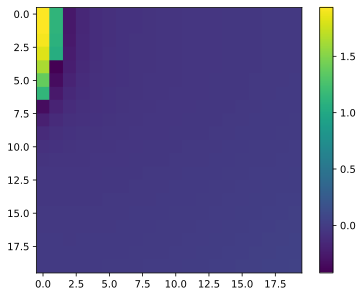

In [4]:
plt.imshow(relative_anharm_list)
plt.colorbar()

In [5]:
np.min(relative_anharm_list)

-0.42173557357364094

### E01 vs ng1 vs ng2

In [19]:
nmon = Nmon(N=1, M=2,EJM=1, EJN=1)
EC_const = nmon.EC_total

EJM_EC = 100
EJN_EC = 100

nmon = Nmon(N=1, M=2,EJM=EJM_EC*nmon.EC_total, EJN=EJN_EC*nmon.EC_total)

ng1_list = np.linspace(0, 0.5, 2)
ng2_list = np.linspace(0, 0.5, 2)

w01_list = np.zeros([2, 2])

for i, ng1 in enumerate(tqdm(ng1_list)):
    for j, ng2 in enumerate(ng2_list):
        nmon.hamiltonian_calc(flux=0, ng=[ng1, ng2], make_plot=False)

        w01_list[i, j] = nmon.transition_freqs[0]

print((np.max(w01_list) - np.min(w01_list))/np.min(w01_list))

100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

0.007470192290784885


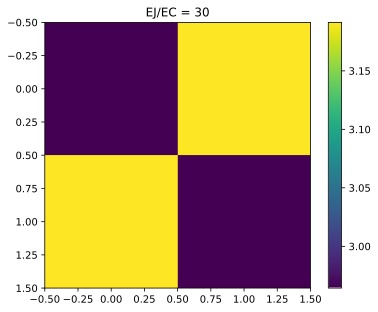

In [16]:
plt.imshow(w01_list)
plt.title("EJ/EC = 30")
plt.colorbar()

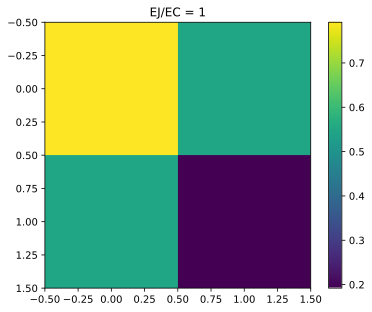

In [10]:
plt.imshow(w01_list)
plt.title("EJ/EC = 1")
plt.colorbar()

In [11]:
s = nmon.nmon_circ.sym_hamiltonian(float_round=6)
s, nmon.N, nmon.M, nmon.EJM, nmon.EJN

<IPython.core.display.Latex object>

(None, 1, 2, 19.268209461493687, 1.9268209461493684)

In [9]:
C_matr = nmon.nmon_circ.symbolic_circuit._capacitance_matrix()
C_matr, np.linalg.inv(C_matr)

(array([[ 125.25 , -125.   ],
        [-125.   ,  125.125]]),
 array([[2.66755496, 2.66489007],
        [2.66489007, 2.67021985]]))

In [10]:
nmon.nmon_circ.offset_charge_transformation()

<IPython.core.display.Latex object>

In [12]:
nmon.nmon_circ.variable_transformation()

<IPython.core.display.Latex object>

In [27]:
Matr = nmon.nmon_circ.transformation_matrix

M_inv  = np.linalg.inv(Matr)

Matr, M_inv

(array([[1, 1],
        [1, 0]]),
 array([[ 0.,  1.],
        [ 1., -1.]]))

In [33]:
EC_old_basis = M_inv.T @ np.linalg.inv(C_matr) @ M_inv
EC_old_basis

array([[ 2.67021985, -0.00532978],
       [-0.00532978,  0.00799467]])

In [34]:
import sympy as sp

# Define the symbols for the charge operators and gate-induced charges
n1, n2 = sp.symbols('n1 n2', commutative=False)  # Charge operators (non-commutative if necessary)
ng1, ng2 = sp.symbols('ng1 ng2')  # Gate-induced charges

# Assume EC_new is a 2x2 matrix, define it symbolically
# EC11, EC12, EC21, EC22 = sp.symbols('EC11 EC12 EC21 EC22')
# EC_new = sp.Matrix([[EC11, EC12], [EC21, EC22]])
EC_new = EC_old_basis

# Define the charge operator vectors (add ng to each)
n_vector = sp.Matrix([n1 + ng1, n2 + ng2])

# Construct the Hamiltonian using matrix multiplication for the charging energy terms
H_C = n_vector.T * EC_new * n_vector

# Simplify the expression to make it more readable
H_C_simplified = sp.simplify(H_C[0])  # Access the first element as it results in a 1x1 matrix

# Display the Hamiltonian
H_C_simplified


(0.00799467021985389*(ng2 + n2) - 0.00532978014656882*(ng1 + n1))*(ng2 + n2) + (2.670219853431*(ng1 + n1) - 0.00532978014656926*(ng2 + n2))*(ng1 + n1)

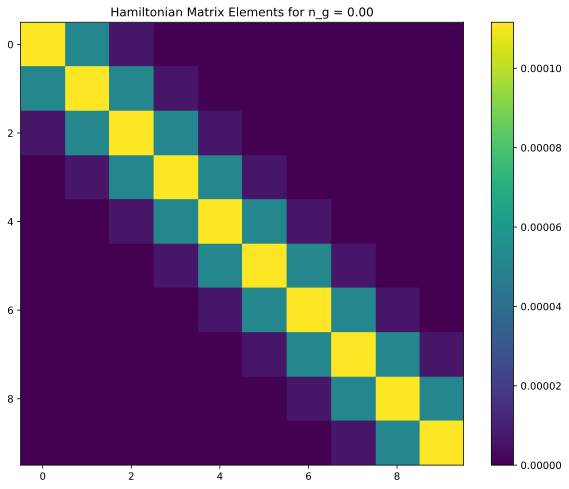

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
E_C = 0.06  # Example value for Charging Energy matrix
E_JN = 4.5  # Josephson Energy
E_JM = 0.9
N = 1  # Number of JJs in the first branch
M = 2  # Number of JJs in the second branch
n_max = 10  # Range of charge states

# Discretization of the phase variable
N_phi = 100
N_phi_trunc = 10
phi = np.linspace(0, 2 * np.pi, N_phi, endpoint=False)

N_ng = 100
# Define charge states and gate charges
n_g_values = np.linspace(-0.1, 0.1, N_ng)

# Define EC as a random symmetric matrix (for demonstration)
# E_C_matrix = np.random.rand(N+M-1, N+M-1)
# E_C_matrix = (E_C_matrix + E_C_matrix.T) / 2  # Ensure it is symmetric

E_C_matrix = EC_old_basis # E_C*np.array([[0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1]])

# Function to create derivative operator with scaled phase variable
def create_derivative_operator(scaling_factor):
    h_phi_scaled = 2 * np.pi / (N_phi) * scaling_factor
    d_dphi_scaled = -1j * (np.diag(np.ones(N_phi - 1), 1) - np.diag(np.ones(N_phi - 1), -1)) / (2 * h_phi_scaled)
    d_dphi_scaled[0, -1] = -1j / (2 * h_phi_scaled)  # Periodic boundary condition
    d_dphi_scaled[-1, 0] = 1j / (2 * h_phi_scaled)
    return d_dphi_scaled

# Create derivative operators for N and M scaling
d_dphi_N = create_derivative_operator(N)
d_dphi_M = create_derivative_operator(M)

# Initialize the Hamiltonian array for each gate charge
H_matrices = np.zeros((N_phi, N_phi, len(n_g_values)), dtype=complex)

num_n_g = 0

# Construct the Hamiltonian iteratively for each gate charge
for idx, n_g in enumerate(n_g_values):
    H_kinetic = np.zeros((N_phi, N_phi), dtype=complex)
    for i in range(N + M - 1):
        for j in range(N + M - 1):
            n_operator_i = d_dphi_N if i < N else d_dphi_M  # Choose the correct scaled operator
            n_operator_j = d_dphi_N if j < N else d_dphi_M
            H_kinetic += 4*E_C_matrix[i, j] * (n_operator_i/1e4 - n_g *(i == num_n_g) * np.eye(N_phi)).conj().T @ (n_operator_j/1e4 - n_g * (j == num_n_g)* np.eye(N_phi))

    # Josephson terms with scaled cosine and sine matrices
    phi = np.linspace(0, 2 * np.pi, N_phi, endpoint=False)
    cos_phi_N = np.diag(np.cos(N * phi))
    cos_phi_M = np.diag(np.cos(M * phi))
    H_Josephson = 0*( -M * E_JM * cos_phi_N - N * E_JN * cos_phi_M)
    
    # Total Hamiltonian for this gate charge
    H_matrices[:, :, idx] = H_kinetic + H_Josephson

# print(H_matrices[:, :, N_ng//2+1])
# Numerically differentiate the Hamiltonian with respect to n_g
dH_dng = np.gradient(H_matrices, n_g_values, axis=2)

# Select the derivative at the central n_g value
dH_dng_at_ng0 = dH_dng[:N_phi_trunc, :N_phi_trunc, N_ng//2]  # assuming n_g0 corresponds to the middle index

matrix_elements = H_matrices[:N_phi_trunc, :N_phi_trunc, N_ng//2+1]
# print(matrix_elements)
# Example visualization for a selected gate charge
selected_idx = len(n_g_values) // 2
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(matrix_elements), cmap='viridis')
plt.colorbar()
plt.title(f'Hamiltonian Matrix Elements for n_g = {n_g_values[selected_idx]:.2f}')
# plt.xlabel('Phase (radians)')
# plt.ylabel('Charge State')
plt.show()
